# Section 4.2.3. GAN Implementation

## 1. Training Stage

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchsummary import summary

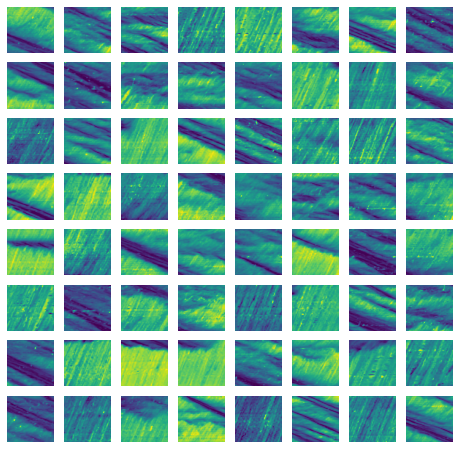

In [2]:
dataset = torch.load('dataset/i24_normalized.pt')

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(dataset[np.random.randint(dataset.shape[0])][0], origin="lower" )
        ax[i, j].axis("off")
        
# Create data loaders
data_loader = DataLoader(dataset, batch_size=250, shuffle=True)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, input_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen_fc = nn.Sequential(
            nn.Linear(z_dim, 128 * 8 * 8),
            nn.ReLU(True)
        )
        self.gen_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, input_dim, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.gen_fc(x)
        x = x.view(x.size(0), 128, 8, 8)
        x = self.gen_conv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.disc_conv = nn.Sequential(
            nn.Conv2d(input_dim, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.disc_fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.disc_conv(x)
        x = x.view(x.size(0), -1)
        x = self.disc_fc(x)
        return x

![alt text](img/GAN_edit.png "Title")

In [4]:
# Hyperparameters
z_dim = 64  # Size of the noise vector
lr = 0.0002
beta1 = 0.5

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = dataset.shape[1]
generator = Generator(z_dim, input_dim).to(device)
discriminator = Discriminator(input_dim).to(device)

# Optimizers
optim_gen = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

In [5]:
print('Change of dimension of the input of the generator')
summary(generator, (1, 1, 64))

Change of dimension of the input of the generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 1, 1, 8192]         532,480
              ReLU-2           [-1, 1, 1, 8192]               0
   ConvTranspose2d-3           [-1, 64, 16, 16]         131,136
       BatchNorm2d-4           [-1, 64, 16, 16]             128
              ReLU-5           [-1, 64, 16, 16]               0
   ConvTranspose2d-6           [-1, 32, 32, 32]          32,800
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
   ConvTranspose2d-9            [-1, 1, 64, 64]             513
             Tanh-10            [-1, 1, 64, 64]               0
Total params: 697,121
Trainable params: 697,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass 

In [6]:
print('Change of dimension of the input of the discriminator')
summary(discriminator, (1, 64, 64))

Change of dimension of the input of the discriminator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             544
         LeakyReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          32,832
       BatchNorm2d-4           [-1, 64, 16, 16]             128
         LeakyReLU-5           [-1, 64, 16, 16]               0
            Conv2d-6            [-1, 128, 8, 8]         131,200
       BatchNorm2d-7            [-1, 128, 8, 8]             256
         LeakyReLU-8            [-1, 128, 8, 8]               0
            Linear-9                    [-1, 1]           8,193
          Sigmoid-10                    [-1, 1]               0
Total params: 173,153
Trainable params: 173,153
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward p

The learning process is guided by a value function $V(\phi, \theta)$, defined as follows:

- $V(\phi, \theta) = \mathbb{E}_{\mathbf{x} \sim p_{data}(\mathbf{x})}[\log D_{\phi}(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})}[\log(1 - D_{\phi}(G_{\theta}(\mathbf{z})))]$

The learning process involves simultaneously optimizing the parameters of both $G$ and $D$, specifically $\theta$ and $\phi$, through gradient-based methods as shown below. This process alternates between the following two steps:
 

- $ Goal: \phi^{*},\theta^{*} = \min_{G_{\theta}} \max_{G_{\phi}} V(\phi, \theta)$

In [7]:
# Training loop
num_epochs = 50
real_label = 1.0
fake_label = 0.0

for epoch in range(num_epochs):
    running_loss_D = 0.0
    running_loss_G = 0.0
    for data in data_loader:
        
        # Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with real batch
        discriminator.zero_grad()
        real_data = data.to(device)
        batch_size = real_data.size(0)
        label = torch.full((batch_size,), real_label, device=device).float()
        
        output = discriminator(real_data).view(-1)
        # errD_real = -[y_i * log(D(x_i))] where y_i=1 for real
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(batch_size, z_dim, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        # errD_fake = -[(1 - y_i) * log(1 - D(G(z_i)))] where y_i=0 for fake
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optim_disc.step()
        
        running_loss_D += errD.item()*batch_size

        # Update Generator: maximize log(D(G(z)))
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = discriminator(fake).view(-1)
        # errG = -[y_i * log(D(G(z_i)))] where y_i=1 for real
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optim_gen.step()
        
        running_loss_G += errG.item()*batch_size
    
    # Print averaged loss per epoch
    avg_loss_D = running_loss_D / dataset.shape[0]
    avg_loss_G = running_loss_G / dataset.shape[0]
    print(f'Epoch [{epoch+1:02}/{num_epochs}] Loss_D: {avg_loss_D:>6.4f} Loss_G: {avg_loss_G:>6.4f}')

# Save the model after training
torch.save(generator.state_dict(), 'models/generator.pth')
torch.save(discriminator.state_dict(), 'models/discriminator.pth')
print("Generator and Discriminator models saved.")

Epoch [01/50] Loss_D: 0.0531 Loss_G: 5.6984
Epoch [02/50] Loss_D: 0.0911 Loss_G: 5.8705
Epoch [03/50] Loss_D: 0.0056 Loss_G: 6.3437
Epoch [04/50] Loss_D: 0.5827 Loss_G: 3.7078
Epoch [05/50] Loss_D: 0.4465 Loss_G: 3.1070
Epoch [06/50] Loss_D: 0.3791 Loss_G: 3.2187
Epoch [07/50] Loss_D: 0.2916 Loss_G: 2.8298
Epoch [08/50] Loss_D: 0.3426 Loss_G: 2.9431
Epoch [09/50] Loss_D: 0.3301 Loss_G: 3.0171
Epoch [10/50] Loss_D: 0.6120 Loss_G: 2.5728
Epoch [11/50] Loss_D: 0.7129 Loss_G: 2.4409
Epoch [12/50] Loss_D: 0.7270 Loss_G: 2.7299
Epoch [13/50] Loss_D: 0.6161 Loss_G: 2.5999
Epoch [14/50] Loss_D: 0.6667 Loss_G: 2.9802
Epoch [15/50] Loss_D: 0.6060 Loss_G: 3.0061
Epoch [16/50] Loss_D: 0.7285 Loss_G: 2.7107
Epoch [17/50] Loss_D: 0.6765 Loss_G: 2.6788
Epoch [18/50] Loss_D: 0.7174 Loss_G: 2.5607
Epoch [19/50] Loss_D: 0.7080 Loss_G: 2.3405
Epoch [20/50] Loss_D: 0.5896 Loss_G: 2.6780
Epoch [21/50] Loss_D: 0.5703 Loss_G: 2.9251
Epoch [22/50] Loss_D: 0.5818 Loss_G: 2.8088
Epoch [23/50] Loss_D: 0.5760 Los

## 2. Testing Stage

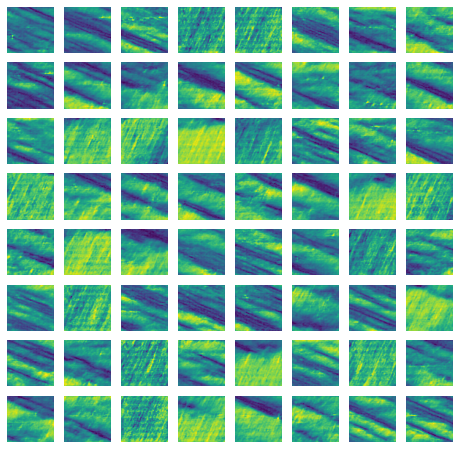

In [8]:
device = "cpu"

z_dim = 64
input_dim = 64

generator = Generator(z_dim, input_dim).to(device)
generator.load_state_dict(torch.load('models/generator.pth', map_location="cpu"))
generator.eval()

# Sample from the latent space
with torch.no_grad():
    z = torch.randn(64, z_dim).to(device)
    sample = generator(z).cpu()
    sample = sample.numpy()

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(sample[i * 8 + j][0,:,:], origin="lower")
        ax[i, j].axis("off")

plt.savefig("img/GAN_result.png", dpi=500)
plt.show()